# Rasdaman Data Access - First Tries

*Rob Knapen, Wageningen Environmental Research*

This notebook covers some first tries with using Rasdaman coverage services (WCS and WCPS).

In [1]:
# this notebook uses dotenv to retrieve secrets from environment variables
# get it with: pip install python-dotenv

%load_ext dotenv
%dotenv

In [2]:
import os

# read the secret information ...
#   Create a .env file in the notebooks folder first that has entries like:
#
#   RASDAMAN_SERVICE_ENDPOINT=<url>
#   RASDAMAN_CRED_USERNAME=<rasdaman_endpoint_username>
#   RASDAMAN_CRED_PASSWORD=<rasdaman_endpoint_password>
#   etc.

rasdaman_username = os.getenv("RASDAMAN_CRED_USERNAME")
rasdaman_password = os.getenv("RASDAMAN_CRED_PASSWORD")
rasdaman_endpoint = os.getenv("RASDAMAN_SERVICE_ENDPOINT")

base_wcs_url = rasdaman_endpoint + "?service=WCS&version=2.1.0"

## Using Web Coverage Service (WCS)

### WCS - GetCapabilities

In [22]:
import requests
import json
import xmltodict

# retrieve a description of the WCS using the GetCapabilities request
response = requests.get(base_wcs_url + "&request=GetCapabilities", auth=(rasdaman_username, rasdaman_password))
wcs_capabilities = xmltodict.parse(response.content)
print(json.dumps(wcs_capabilities, indent=2))

{
  "wcs:Capabilities": {
    "@version": "2.1.0",
    "@xsi:schemaLocation": "http://www.opengis.net/wcs/2.1 http://schemas.opengis.net/wcs/2.1/wcsGetCapabilities.xsd",
    "@xmlns:wcs": "http://www.opengis.net/wcs/2.1",
    "@xmlns:xsi": "http://www.w3.org/2001/XMLSchema-instance",
    "@xmlns:gml": "http://www.opengis.net/gml/3.2",
    "@xmlns:swe": "http://www.opengis.net/swe/2.0",
    "@xmlns:ows": "http://www.opengis.net/ows/2.0",
    "@xmlns:xlink": "http://www.w3.org/1999/xlink",
    "@xmlns:rasdaman": "http://www.rasdaman.org",
    "@xmlns:int": "http://www.opengis.net/wcs/interpolation/1.0",
    "@xmlns:crs": "http://www.opengis.net/wcs/service-extension/crs/1.0",
    "@xmlns:inspire_dls": "http://inspire.ec.europa.eu/schemas/inspire_dls/1.0",
    "@xmlns:inspire_common": "http://inspire.ec.europa.eu/schemas/common/1.0",
    "ows:ServiceIdentification": {
      "ows:Title": "rasdaman",
      "ows:Abstract": "rasdaman server - free download from www.rasdaman.org",
      "ows:S

In [23]:
# list the WCS contents
wcs_coverage_summary = wcs_capabilities['wcs:Capabilities']['wcs:Contents']['wcs:CoverageSummary']
print(json.dumps(wcs_coverage_summary, indent=2))

{
  "wcs:CoverageId": "imperviousness",
  "wcs:CoverageSubtype": "RectifiedGridCoverage",
  "ows:WGS84BoundingBox": {
    "ows:LowerCorner": "-27.3444 27.0428",
    "ows:UpperCorner": "35.4948 72.2158"
  },
  "ows:BoundingBox": {
    "@crs": "http://localhost:8080/rasdaman/def/crs/EPSG/0/4326",
    "@dimensions": "2",
    "ows:LowerCorner": "27.04280000000000 -27.3444",
    "ows:UpperCorner": "72.2158 35.4948"
  },
  "ows:AdditionalParameters": {
    "ows:AdditionalParameter": [
      {
        "ows:Name": "sizeInBytes",
        "ows:Value": "283863518160"
      },
      {
        "ows:Name": "sizeInBytesWithPyramidLevels",
        "ows:Value": "307495836610"
      },
      {
        "ows:Name": "axisList",
        "ows:Value": "Lat,Lon"
      }
    ]
  }
}


### WCS - DescribeCoverage

In [24]:
# retrieve a description of a coverage using the DescribeCoverage request
coverage_id = wcs_coverage_summary['wcs:CoverageId']

response = requests.get(base_wcs_url + "&request=DescribeCoverage&coverageId=" + coverage_id,
                        auth=(rasdaman_username, rasdaman_password)
                        )
wcs_coverage_description = xmltodict.parse(response.content)
print(json.dumps(wcs_coverage_description, indent=2))

{
  "wcs:CoverageDescriptions": {
    "@xsi:schemaLocation": "http://www.opengis.net/wcs/2.0 http://schemas.opengis.net/wcs/2.0/wcsDescribeCoverage.xsd",
    "@xmlns:wcs": "http://www.opengis.net/wcs/2.0",
    "@xmlns:xsi": "http://www.w3.org/2001/XMLSchema-instance",
    "@xmlns:gml": "http://www.opengis.net/gml/3.2",
    "@xmlns:swe": "http://www.opengis.net/swe/2.0",
    "@xmlns:ows": "http://www.opengis.net/ows/2.0",
    "@xmlns:xlink": "http://www.w3.org/1999/xlink",
    "@xmlns:rasdaman": "http://www.rasdaman.org",
    "@xmlns:gmlcov": "http://www.opengis.net/gmlcov/1.0",
    "wcs:CoverageDescription": {
      "@gml:id": "imperviousness",
      "gml:boundedBy": {
        "gml:Envelope": {
          "@srsName": "http://localhost:8080/rasdaman/def/crs/EPSG/0/4326",
          "@axisLabels": "Lat Lon",
          "@uomLabels": "degree degree",
          "@srsDimension": "2",
          "gml:lowerCorner": "27.0428 -27.3444",
          "gml:upperCorner": "72.2158 35.4948"
        }
     

### WCS - GetCoverage

In [25]:
# Sandefjord region
# subset_lat = "&subset=Lat(59.10, 59.20)"
# subset_long = "&subset=Long(10.20, 10.30)"

# Tromso region
subset_lat = "&subset=Lat(69.60, 69.70)"
subset_long = "&subset=Long(18.90, 19.00)"

cov_id = "&COVERAGEID=" + coverage_id
encode_format = "&FORMAT=tiff"

response = requests.get(
    base_wcs_url + "&request=GetCoverage" + cov_id + subset_long + subset_lat + encode_format,
    auth=(rasdaman_username, rasdaman_password),
    verify=False)

wcs_coverage_data = response.content

# show content if there was an error
if not response.ok:
    dict = xmltodict.parse(wcs_coverage_data)
    print(json.dumps(dict, indent=2))

/vsimem/b2870431-9d22-4002-a2f9-c8ec21f4d74a/b2870431-9d22-4002-a2f9-c8ec21f4d74a.tif 1 1000 1000
BoundingBox(left=18.9, bottom=69.6, right=19.0, top=69.7)


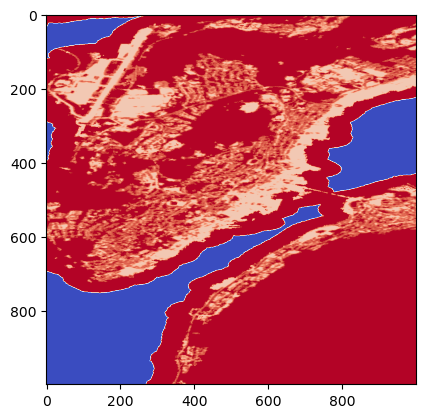

In [26]:
from matplotlib import pyplot
from rasterio.io import MemoryFile
from rasterio.plot import show_hist

with MemoryFile(wcs_coverage_data) as memfile:
    with memfile.open() as ds:
        print(ds.name, ds.count, ds.width, ds.height)
        print(ds.bounds)
        ds_array = ds.read(1)
        # show_hist(ds_array, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled')
        pyplot.imshow(ds_array, cmap='coolwarm_r')

In [27]:
# another way to visualise the retrieved coverage data
from IPython.display import Image
Image(data=wcs_coverage_data)

## Using Web Coverage Processing Service (WCPS)

In [28]:
query = '''
for $c in (imperviousness)
return
  encode(
    $c[ Lat(69.60, 69.70), Long(18.90, 19.00)" ],
    "image/tiff"

  )
'''

response = requests.get(
    base_wcs_url + "&request=ProcessCoverage&query=" + query,
    auth=(rasdaman_username, rasdaman_password),
    verify=False)

wcps_coverage_data = response.content

# show content if there was an error
if not response.ok:
    dict = xmltodict.parse(wcps_coverage_data)
    print(json.dumps(dict, indent=2))

{
  "ows:ExceptionReport": {
    "@version": "2.0.1",
    "@xsi:schemaLocation": "http://www.opengis.net/ows/2.0 http://schemas.opengis.net/ows/2.0/owsExceptionReport.xsd",
    "@xmlns:ows": "http://www.opengis.net/ows/2.0",
    "@xmlns:xsi": "http://www.w3.org/2001/XMLSchema-instance",
    "@xmlns:xlink": "http://www.w3.org/1999/xlink",
    "ows:Exception": {
      "@exceptionCode": "AccessDenied",
      "ows:ExceptionText": "User 'fairicube_eox' does not have role 'PRIV_OWS_WCS_PROCESS_COV' to process request '/rasdaman/ows?service=WCPS&version=1.0.0&request=ProcessCoverages&query=\nfor $c in (imperviousness)\nreturn\n  encode(\n    $c[ Lat(69.60, 69.70), Long(18.90, 19.00)\" ],\n    \"image/tiff\"\n\n  )\n'."
    }
  }
}
